In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#!pip install tensorflow==1.15.0
import tensorflow as tf
tf.__version__

'1.15.0'

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters # 3/23 : 256,512 -> (690,1600)(X) , (704,1600)(O)
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 3

# 파일 경로 설정
drive_path='/content/drive/My Drive/Colab Notebooks/webtoon_data/u-net-data/'
TRAIN_PATH = drive_path # drive_path='/content/sample_data/'

TRAIN_PATH_IMG=TRAIN_PATH+'train_images/'
TRAIN_PATH_MASK=TRAIN_PATH+'train_masks/'

TEST_PATH = drive_path
TEST_PATH_IMG=TEST_PATH+'test_images/' # 예측할 데이터 파일
#TEST_PATH_MASK=TEST_PATH+'test_masks/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [0]:
# Get train and test IDs
# train images와 mask를 정렬해서 각각 대비되는지 확인
'''
next의 [0]번 결과는 특정 디렉토리의 위치 값을 저장
next의 [1]번 결과는 특정 디렉토리의 모든 하위 디렉토리 리스트를 저장
next의 [2]번 결과는 특정 디렉토리에 포함된 모든 파일 리스트를 저장
'''
test_ids_img = next(os.walk(TEST_PATH_IMG))[2] 
test_ids_img.sort()

#test_ids_mask = next(os.walk(TEST_PATH_MASK))[2]
#test_ids_mask.sort()

train_ids_img = next(os.walk(TRAIN_PATH_IMG))[2]
train_ids_img.sort()
train_ids_mask = next(os.walk(TRAIN_PATH_MASK))[2]
train_ids_mask.sort()


In [0]:
train_ids_img[:3] # 출력되는지 확인

['11_1_000.jpg', '11_1_001.jpg', '11_1_002.jpg']

In [0]:
train_ids_mask[:3] # 밑의 'train_ids_img'이미지와 맞게 출력되는지 확인

['11_1_000_mask.jpg', '11_1_001_mask.jpg', '11_1_002_mask.jpg']

In [0]:
# 출력되는지 확인
next(os.walk(TRAIN_PATH))[1][-2:]


['predict_images', '.ipynb_checkpoints']

In [0]:
for n in range(len(train_ids_img)):
    if(n<10):
        print(n, ":",train_ids_img[n],',',train_ids_mask[n])
    

0 : 11_1_000.jpg , 11_1_000_mask.jpg
1 : 11_1_001.jpg , 11_1_001_mask.jpg
2 : 11_1_002.jpg , 11_1_002_mask.jpg
3 : 11_1_003.jpg , 11_1_003_mask.jpg
4 : 11_1_004.jpg , 11_1_004_mask.jpg
5 : 11_1_005.jpg , 11_1_005_mask.jpg
6 : 11_1_006.jpg , 11_1_006_mask.jpg
7 : 11_1_007.jpg , 11_1_007_mask.jpg
8 : 11_1_008.jpg , 11_1_008_mask.jpg
9 : 11_1_009.jpg , 11_1_009_mask.jpg


In [0]:
# Get and resize train images and masks
    # mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    # mask = np.maximum(mask, mask_)
    # 여기서 오류가 날때 폴더에 숨김파일 thumbs.db가 있는지 확인해주세요. 미리보기 저장 파일로 숨김파일로
    # 있을 수 있습니다. 폴더에서 숨김파일 항목 체크하면 확인할 수 있습니다.
X_train = np.zeros((len(train_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids_img), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n in tqdm(range(len(train_ids_img)), total=len(train_ids_img)): # tqdm : for 문 진행바 보여줌
    path_img = TRAIN_PATH_IMG
    path_mask = TRAIN_PATH_MASK
    img_id_=train_ids_img[n]
    mask_id_=train_ids_mask[n]
    
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask_ = imread(path_mask + mask_id_,as_gray=True)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    Y_train[n] = mask_

# Get and resize test images
X_test = np.zeros((len(test_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for  n in tqdm(range(len(test_ids_img)), total=len(test_ids_img)):
    path_img = TEST_PATH_IMG
    #path_mask = TEST_PATH_MASK
    img_id_=test_ids_img[n]
    #mask_id_=test_ids_mask[n]
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 549/549 [05:24<00:00,  1.69it/s]

Getting and resizing test images ... 



100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

Done!


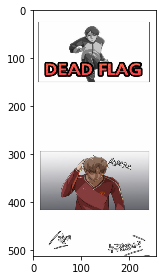

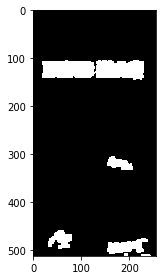

In [0]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids_img))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, 'accuracy'])
model.summary()

In [0]:
MODEL_SAVE_FOLDER_PATH = drive_path+'model_checkPoint/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH+'{epoch:02d}-{val_loss:.4f}.h5'

In [0]:
# Fit model
earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True, save_weights_only= True)
results = model.fit(X_train, Y_train, validation_split=0.02, batch_size=4, epochs=40
                    , callbacks=[earlystopper, checkpointer])

In [0]:
# Predict on train, val and test
# model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

13/13 [==============================] - 0s 32ms/step


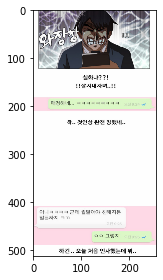

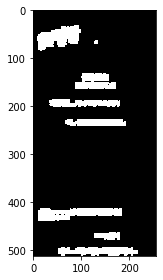

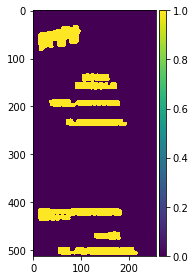

In [0]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

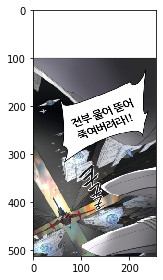

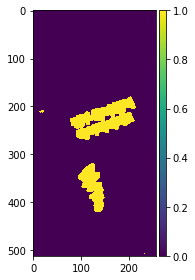

In [0]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()



In [0]:
import cv2  # *255는 위에 mask범위를 보면 0~1인데 마스킹된 부분이 1 -> 노랑으로 되있어서 255를 곱해준다.


In [0]:
cv2.imwrite(drive_path+'predict_images/1_predict.jpg',(preds_test_t[i]*255))

True

In [0]:
len(preds_test_t)

6